In [96]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [97]:
from __future__ import division
import numpy as np
from setup import *
from OrbitalMotion import numerical_orbital_evolution, analytical_orbital_evolution, analytical_split
c,G,Msolar,AU, pc = univeral_constants()

In [98]:
#Choose system parameters 

#---Inner Binary---
m0 = 30*Msolar
m1 = 30*Msolar
f1 = 1e-3 #orbital frequency
a1 = semi_major_axis(m0+m1,f1)
e1 = 0.5 #eccentricity
g1 = np.pi/4
J1 = angular_momentum(m0,m1,e1,a1)#angular momentum. Eq. 12 of Randal

#---Outer Binary
beta=5
a2 = beta * a1
m2 = 10*Msolar
e2 = 0.6

#---Shared---
I = 60 * np.pi/180.0 #Inclination
nmodes = 20 #number of modes to sum over for GW
iota = 20 * np.pi/180  #angle of L vector w.r.t observer LOS 
D = 1e6 * pc #distance from source to observer 1Mpc


#---Integration settings
Tint = 1.0
fs = 1e-1

#---Info for user
status(fs, Tint)


Sampling frequency =  0.1  Hz for an observation period of  1.0  years
Total number of integration steps is  3153600.0
Frequency range is:  3.1709791983764586e-08  -  0.05  Hz


In [99]:
'''
import time 


#The full numerical solution at high resolution 
output = numerical_orbital_evolution(m0,m1,m2,a1,e1,g1,J1,e2,a2,I,fs,Tint)
numerical_motion_highres = output[0]
constants = output[1]
np.save('numerical_refined',numerical_motion_highres)

tstart = time.time()
#and the training set at low resolution
output = numerical_orbital_evolution(m0,m1,m2,a1,e1,g1,J1,e2,a2,I,1e-3,Tint)
numerical_motion_lowres = output[0]
np.save('numerical_coarse',numerical_motion_lowres)
tend = time.time()

print ('Coarse resolution ran in',tend-tstart,' seconds')
'''

Final t =  31536000.0
Finised numericals. 31536000.0 31536000.0 31536000.0 10.0
Numerical orbital evolution has completed with fs =  0.1  Hz and Tobs =  1.0  years
Final t =  31536000.0
Finised numericals. 31536000.0 31536000.0 31536000.0 1000.0
Numerical orbital evolution has completed with fs =  0.001  Hz and Tobs =  1.0  years
Coarse resolution ran in 3.369872808456421  seconds


------- 0 --------
extract ecc
Extract for double trig func
E =  0.0 0.0 0.0
E =  3154000.0 3154000.0 3154000.0
------- 1 --------
extract ecc
Extract for double trig func
E =  3154000.0 3154000.0 3154000.0
E =  6308000.0 6308000.0 6308000.0
------- 2 --------
extract ecc
Extract for double trig func
E =  6308000.0 6308000.0 6308000.0
E =  9462000.0 9462000.0 9462000.0
------- 3 --------
extract ecc
Extract for double trig func
E =  9462000.0 9462000.0 9462000.0
E =  12616000.0 12616000.0 12616000.0
------- 4 --------
extract ecc
Extract for double trig func
E =  12616000.0 12616000.0 12616000.0
E =  15770000.0 15770000.0 15770000.0
------- 5 --------
extract ecc
Extract for double trig func
E =  15770000.0 15770000.0 15770000.0
E =  18924000.0 18924000.0 18924000.0
------- 6 --------
extract ecc
Extract for double trig func
E =  18924000.0 18924000.0 18924000.0
E =  22078000.0 22078000.0 22078000.0
------- 7 --------
extract ecc
Extract for double trig func
E =  22078000.0 22078000.0 

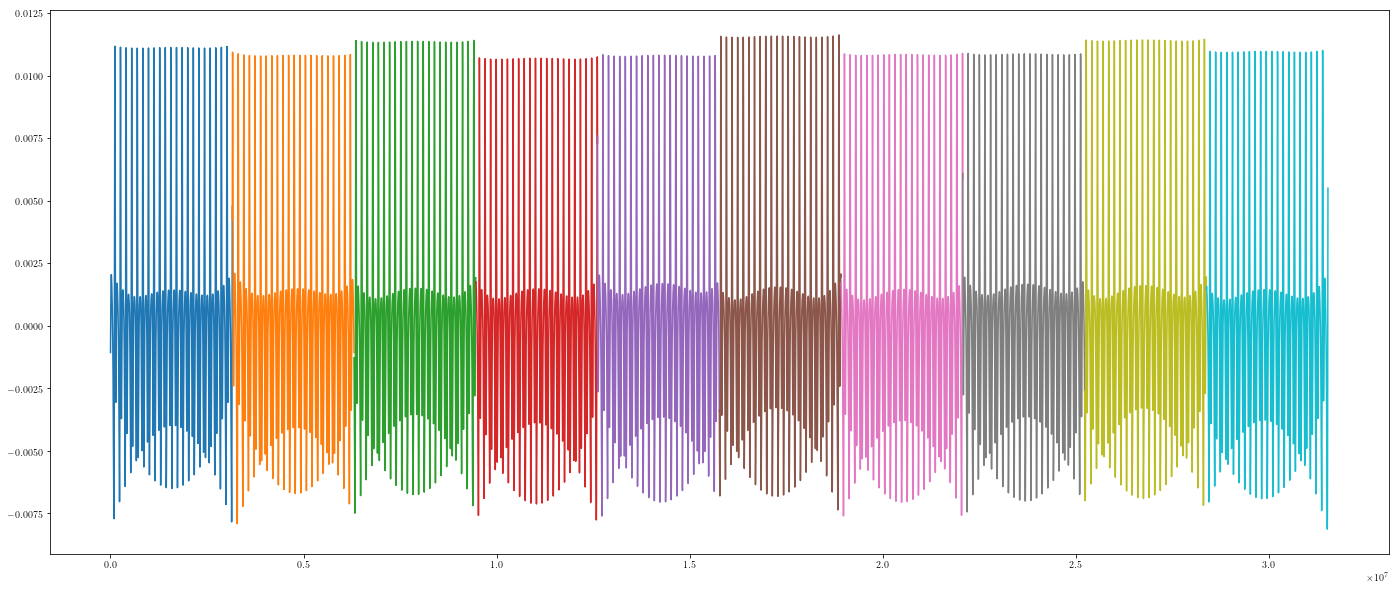

In [100]:
import sys

#temp plotting setup
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(24,10)) 
ax1 = plt.subplot2grid((1,1), (0,0))
#end temp plottign setop


#Load the high resolution data
full_set  = np.load('numerical_refined.npy')

#Load the low resolution data
training_set = np.load('numerical_coarse.npy')

#Create an array to save the outputs
analytical = np.empty_like(full_set)





#Split numerical coarse into N training sets
N = 10
T_seconds = Tint*365*24*3600
t = np.arange(0,T_seconds,1/fs)
Tlim = T_seconds / N



#the time of each training set
tTRAIN = training_set[:,0]
tNUM = full_set[:,0]

#Get the incidence in the coarse data closest to the split point
idx = min(range(len(tTRAIN)), key=lambda i: abs(tTRAIN[i]-Tlim))
Tlim = tTRAIN[idx]


#Get the same point in the numerical data
idx2 = np.where(tNUM == Tlim)[0][0]



for i in range(10):
    print ('-------', i, '--------')
  
    #Slice the training set data
    subset = training_set[i*idx : i*idx + (idx+1), :]

    #Slice the high resolution time
    tHR = full_set[i*idx2 : i*idx2 + (idx2+1),0]
    
    
    #print ('Time endpoints:', tHR[0], tHR[-1])
   # print ('Time endpoints:', subset[0,0],subset[-1,0])
    #print (T_seconds,t[-1], tTRAIN[-1], tNUM[-1])
    #sys.exit()

    #Use this training set data to get a semi-analytical solution over the relevant time interval
    output = analytical_split(subset,tHR,constants)

    #Are the endpoints the same?
    w = 1
    #ax1.plot(output[:,0], output[:,w])
    #ax1.plot(subset[:,0], subset[:,w])

    tN = full_set[i*idx2 : i*idx2 + (idx2+1),0] #this is the same as t subset
    gN = full_set[i*idx2 : i*idx2 + (idx2+1),w]
    
    
    print ('E = ', output[0,0], tHR[0],tN[0])
    print ('E = ', output[-1,0], tHR[-1],tN[-1])
    
    #print ('endpoints. Output STA', output[0,0])
    #print ('endpoints. Numeri STA', full_set[i*idx2,0])
    
    #print ('endpoints. Output END', output[-1,0])
    #print ('endpoints. Numeri END', full_set[i*idx2 + (idx2+1),0])
    
    
    #k = 0
    #print ('H0= ', tN[k],gN[k])
    #print ('K0 =',output[k,0], output[k,w])
    
    #k = -1
    #print ('H= ', tN[k],gN[k])
    #print ('K =',output[k,0], output[k,w])



   
    #ax1.plot(tN,gN)
    ax1.plot(tN, (output[:,w] - gN)/gN)
      
    
    #np.save('eccentricity_data.npy', subset)
    #np.save('eccentricity_dataHR.npy', full_set[i*Lt : i*Lt + (Lt+1),:])
    
    analytical[i*idx2 : i*idx2 + (idx2+1),:] = output

        

lim = 0.025
#ax1.set_ylim(-0.0125,0.0075)

Plotting the orbital parameter evolution
Plotting the orbital parameter evolution
[  0.78539816   0.78554498   0.78569176 ... 681.49077259 681.49107884
 681.49138514]
[  0.78539816   0.78554804   0.78569789 ... 681.49063059 681.49094305
 681.49125557]
[ 1.13086389e-15 -3.89353801e-06 -7.80147470e-06 ...  2.08379654e-07
  1.99264922e-07  1.90114596e-07]
The average percentage error in a was: 2.152681381439472e-06
LIM CHANGES


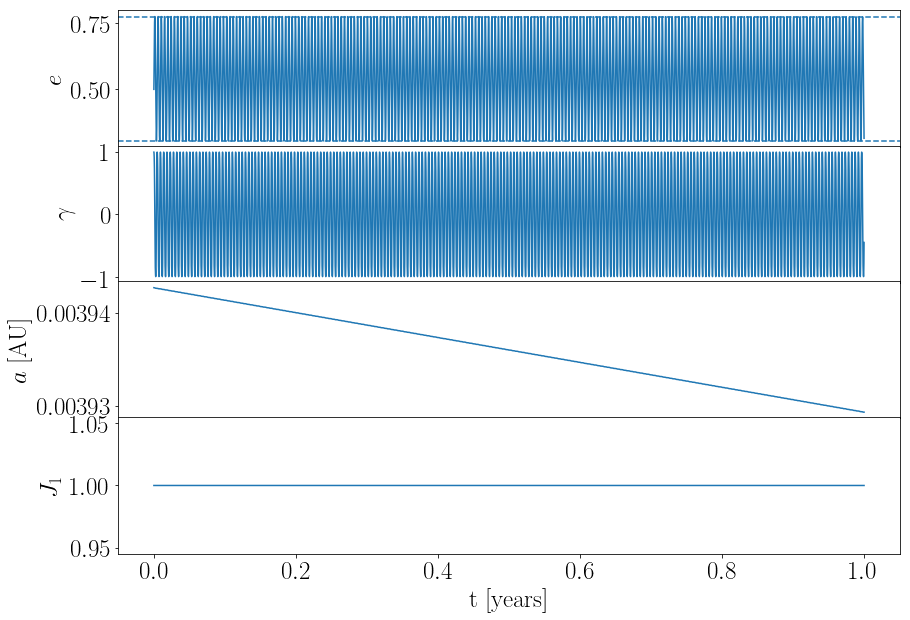

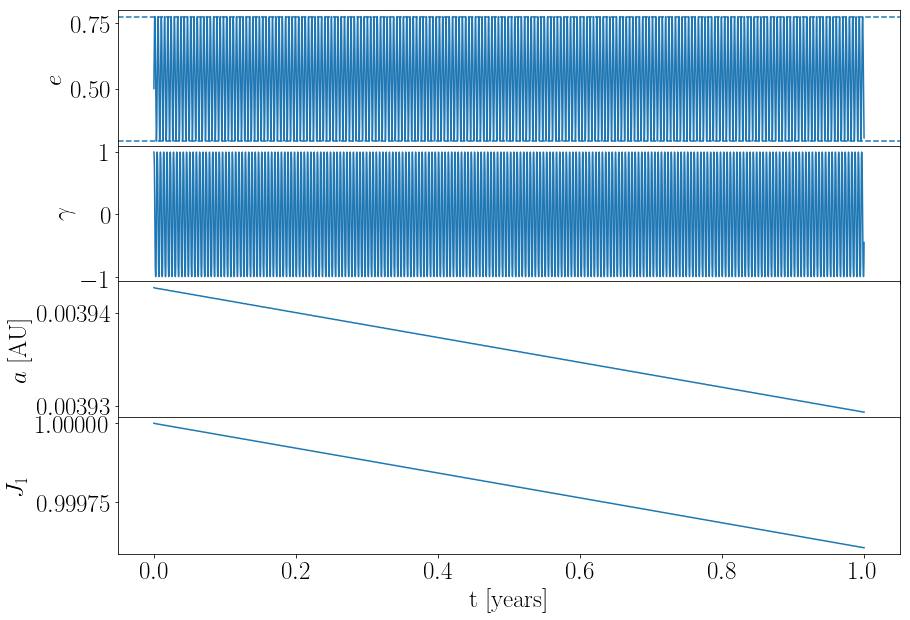

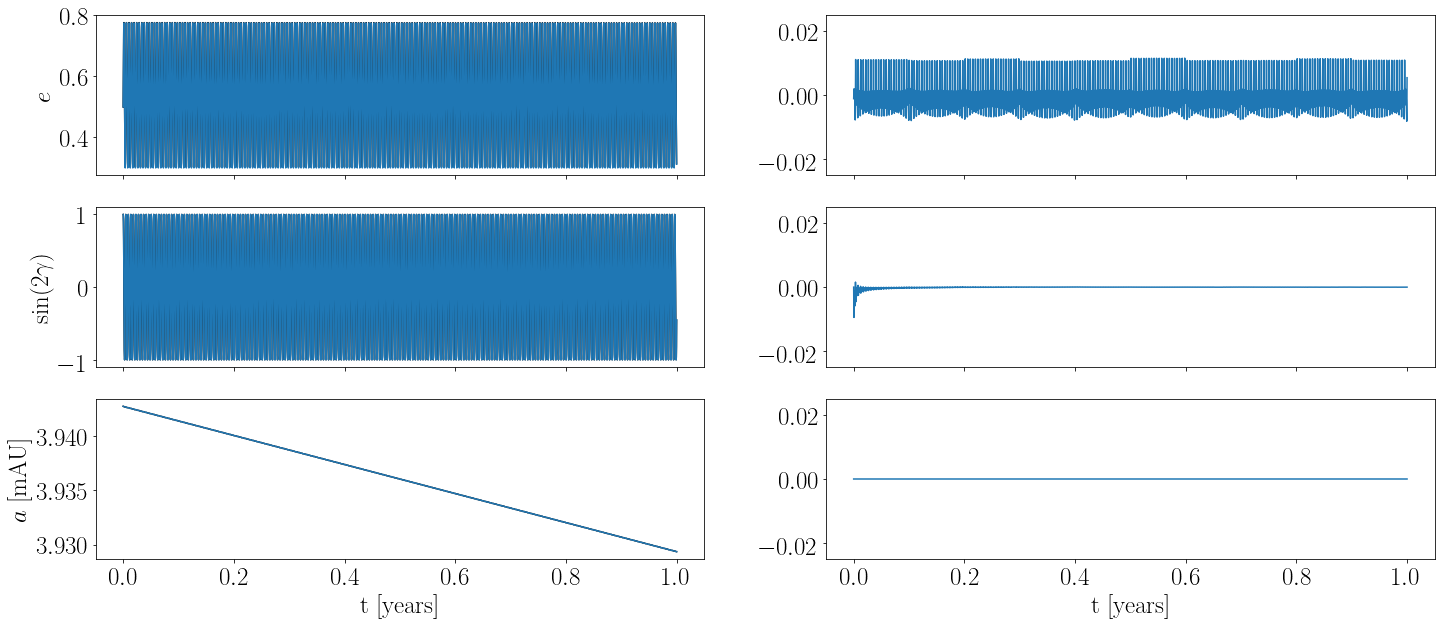

In [101]:
from plot import *
### Now plot and compare
plot_motion(analytical)
plot_motion(full_set)
plot_compare_motion(analytical,full_set)


In [102]:
import GravRadiation as GR
constants = np.array([m0+m1, nmodes,iota,m0*m1/(m0+m1),D])
waveformNR = GR.Gwaves(full_set, constants)
waveformAN = GR.Gwaves(analytical, constants)

Getting the waveform
Mode sum. n =  1.0 20.0
Mode sum. n =  2.0 20.0
Mode sum. n =  3.0 20.0
Mode sum. n =  4.0 20.0
Mode sum. n =  5.0 20.0
Mode sum. n =  6.0 20.0
Mode sum. n =  7.0 20.0
Mode sum. n =  8.0 20.0
Mode sum. n =  9.0 20.0
Mode sum. n =  10.0 20.0
Mode sum. n =  11.0 20.0
Mode sum. n =  12.0 20.0
Mode sum. n =  13.0 20.0
Mode sum. n =  14.0 20.0
Mode sum. n =  15.0 20.0
Mode sum. n =  16.0 20.0
Mode sum. n =  17.0 20.0
Mode sum. n =  18.0 20.0
Mode sum. n =  19.0 20.0
Mode sum. n =  20.0 20.0
Getting the waveform
Mode sum. n =  1.0 20.0
Mode sum. n =  2.0 20.0
Mode sum. n =  3.0 20.0
Mode sum. n =  4.0 20.0
Mode sum. n =  5.0 20.0
Mode sum. n =  6.0 20.0
Mode sum. n =  7.0 20.0
Mode sum. n =  8.0 20.0
Mode sum. n =  9.0 20.0
Mode sum. n =  10.0 20.0
Mode sum. n =  11.0 20.0
Mode sum. n =  12.0 20.0
Mode sum. n =  13.0 20.0
Mode sum. n =  14.0 20.0
Mode sum. n =  15.0 20.0
Mode sum. n =  16.0 20.0
Mode sum. n =  17.0 20.0
Mode sum. n =  18.0 20.0
Mode sum. n =  19.0 20.0
M

Plotting the GW
Max h plus = 1.2623854965230435e-21
Plotting the GW
Max h plus = 1.2796572857599269e-21


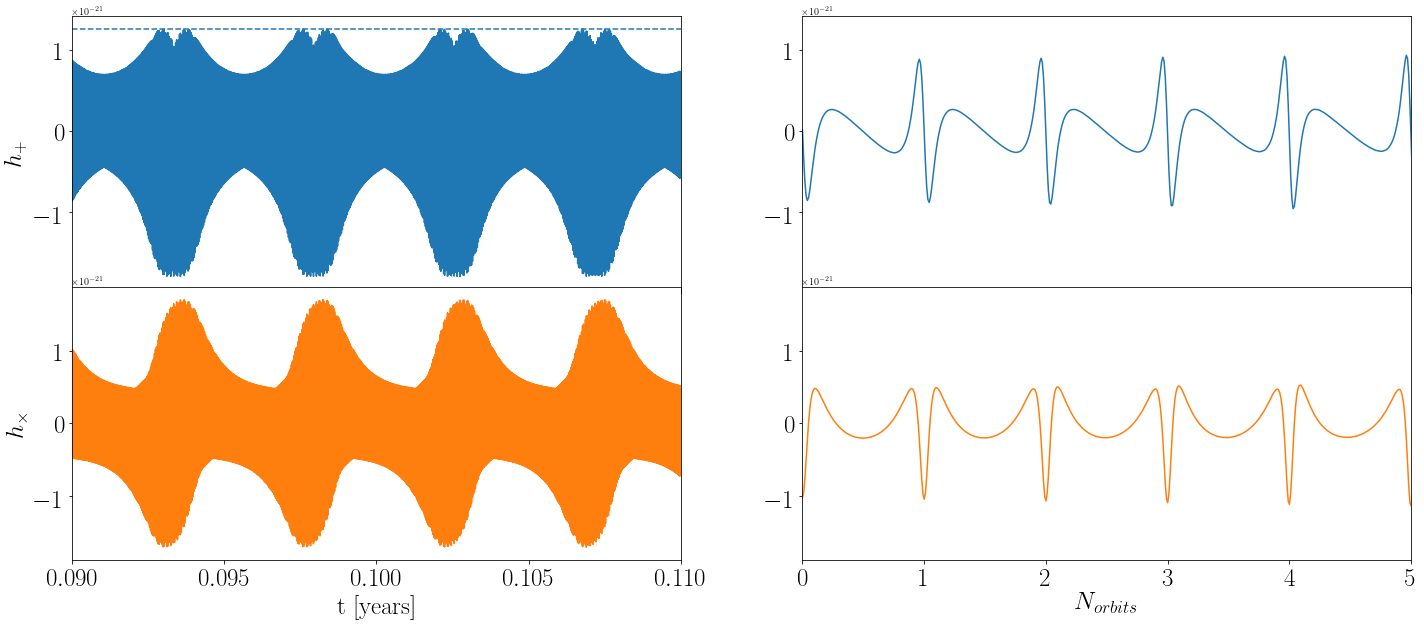

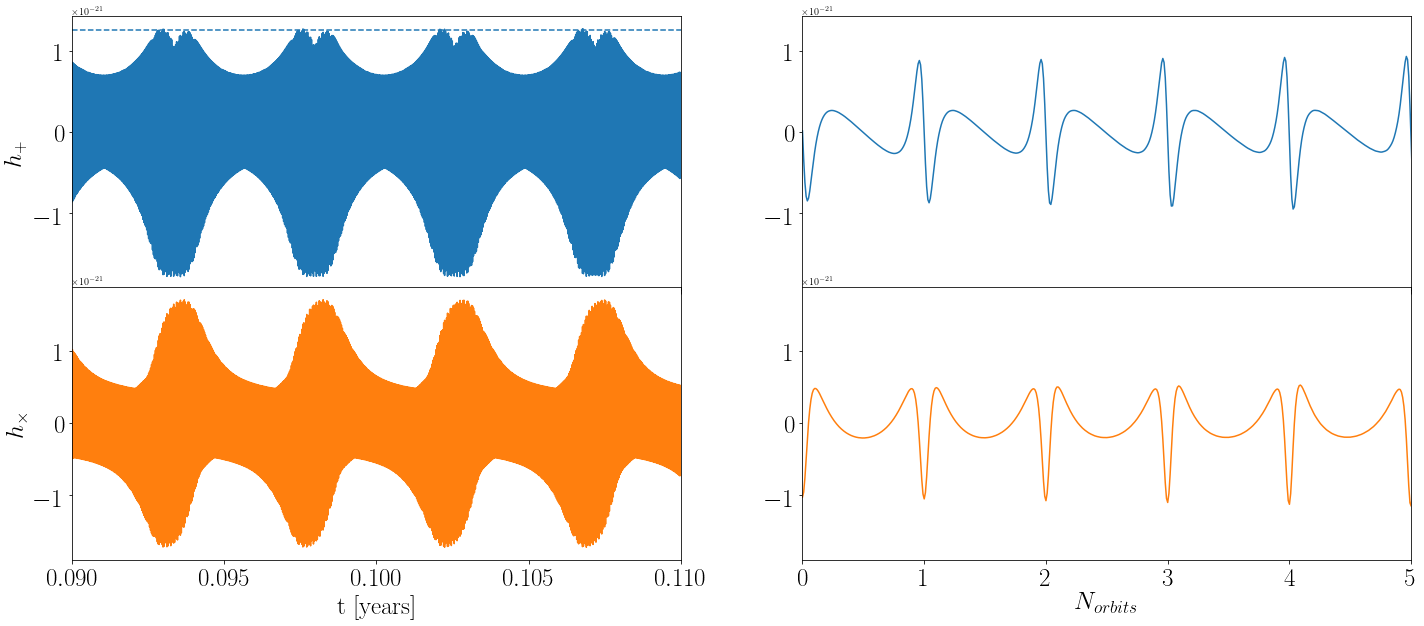

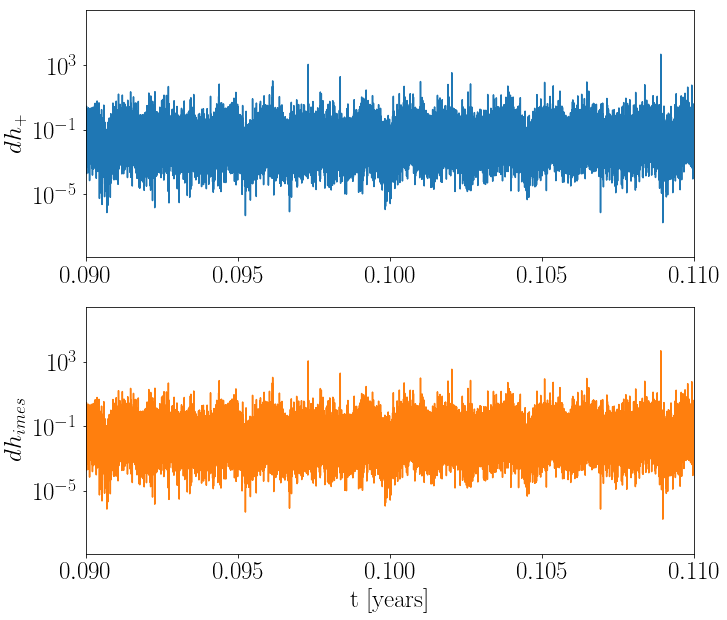

In [103]:
#Plot the GW waveforms
from plot import *
plot_GW(waveformNR,f1)
plot_GW(waveformAN,f1)
compare_GW(waveformNR,waveformAN)

overlap =  0.9884827809006937


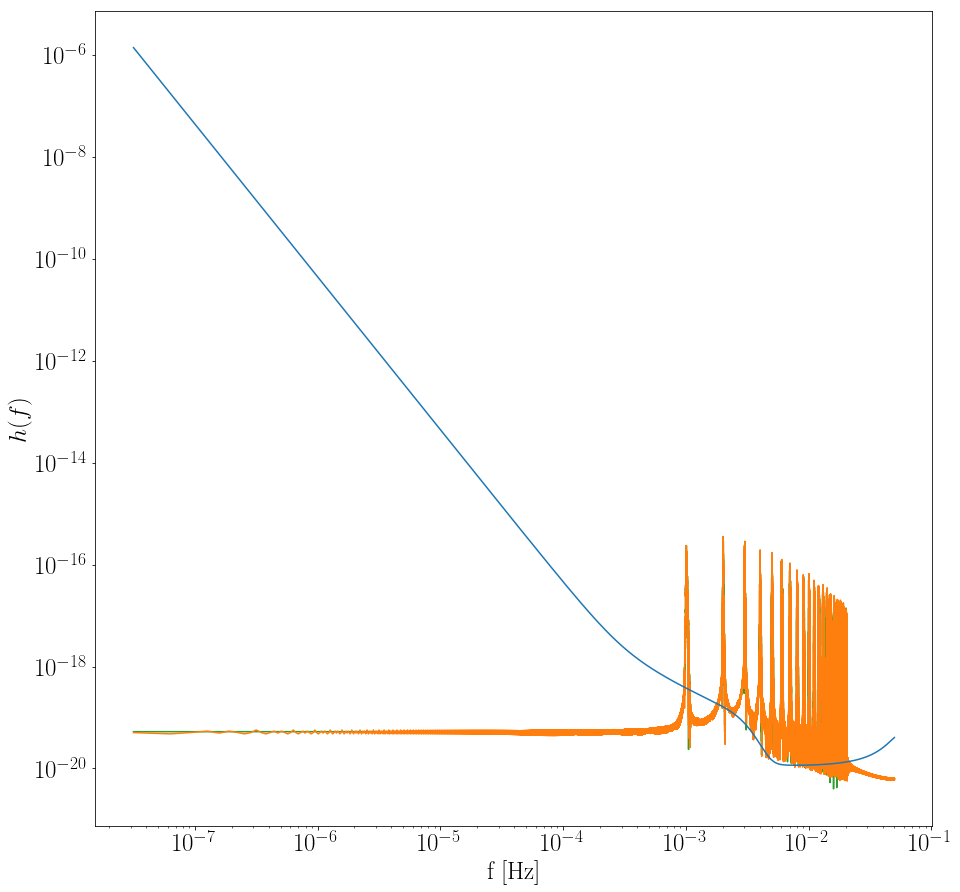

In [107]:
#Go to frequency domain and get the overlap
f,h1,h2, S = GR.overlap(waveformNR,waveformAN)
plot_GW_frequency(f,h1,h2, S)